# **Tutorial:** Dimensionality reduction & neural population models: dynamic

## Introduction

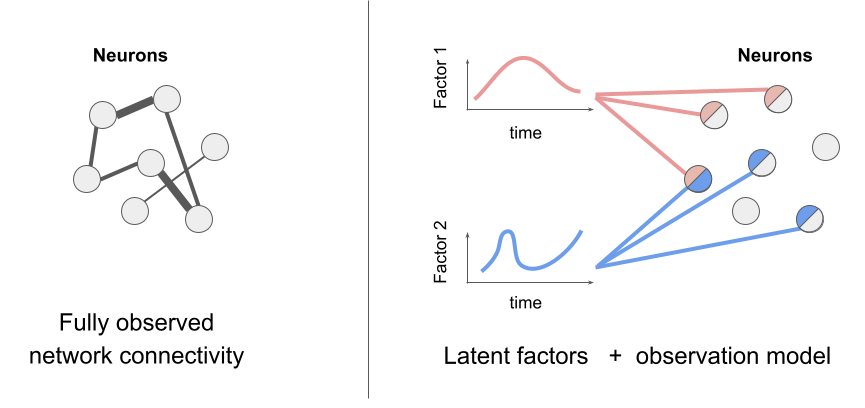

Observed dynamics  | Latent dynamics
-------------------|-------------------
$$\frac{d\mathbf{x}(t)}{dt} = F_c(\mathbf{x}(t),\mathbf{u}(t))$$             |          $$\frac{d\mathbf{z}(t)}{dt} = F_c(\mathbf{z}(t),\mathbf{u}(t))$$           $$\mathbf{x} = C \mathbf{z} + \mathbf\varepsilon$$

*Notation:* The variables in **bold** here correspond to vectors, e.g. a population activity vector $\mathbf{x} = (x_1,x_2,\ldots,x_n)^T$.
External inputs $\mathbf{u}$ in this case would correspond to the inputs from other unobserved neurons (e.g. another brain area).

The key part of the dynamical systems framework is the **evolution function** $F$. Whether continuous $F_c$ or discrete $F_d$, it can tell us a lot about the system:
> The power of the dynamical systems approach to neuroscience, as well as to many other sciences, is that we can tell something, or many things, about a system without knowing all the details that govern the system evolution. We do not even use equations to do that! Some may even wonder why we call it a mathematical theory.        *Eugene Izhikevich [1]*

Therefore, the main goal of the tutorial is to learn how to tell something about the dynamical system knowing $F$.



## Setups

In [1]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets       # interactive display
from matplotlib import rcParams
from scipy.linalg import expm
from scipy.optimize import minimize
rcParams.update({'font.size': 18})

# Autonomous linear dynamical systems (LDS)

Sometimes, we can assume that the system does not receive any external inputs and evolves in time on its own ( $u(t)=0$ ). Such dynamical systems are called **autonomous**. Autonomous systems are common in physics, but also surprisingly applicable to some biological neural networks, as we will see in the last part of the tutorial. Lack of external inputs greatly simplifies the analysis of the dynamics $F$, so let us assume **no** external inputs for now.

As a warmup, let us start with a 1D autonomous continuous-time dynamical system:

$\frac{dx}{dt} = \dot x = a x; \qquad x(0) = x_0 \tag{1} $

We are looking at a so-called *initial value problem* here: we know the state of the system $x_0$ at $t=0$, but we want to make a forecast into the future and find $x(t)$ for $t>0$.

## Solving a 1D linear dynamics equation
Let us solve equation (1) both numerically and analytically.

For analytical solution, let us reorder the variables and integrate both sides of the equation just on paper:

$$\int_{x_0}^{x_t} \frac{dx}{x} = \int_{0}^t a dt \tag{2a}$$

For numerical integration, we will use the *forward Euler* scheme:

$$\frac{dx}{dt} \approx \frac{\Delta x}{\Delta t} = \frac{x_{n+1} - x_n}{\Delta t} \tag{2b}$$

We can then write down an analytical solution at any time point $t$ based on (2a), and also get a numerical approximation of the same integral by applying the update rule $x_{n+1} \rightarrow x_n$ based on (2b) in a for-loop:

### **Exercise 1:** Analytical vs numerical solutions
Complete the missing lines in the code below. Does analytical solution match the numerical solution? 

In [2]:
def analytical_1D_solution(x0,a,t):
    ''' Finds a solution of x' = ax, for x(t), given x(0) = x0 '''
    xt = x0 * np.exp(a*t) # 2remove
    return xt

def numerical_1D_solution(x0,a,t,dt=0.001):
    ''' Integrates x' = ax using a forward Euler scheme, given x(0) = x0;
    Returns x(t) '''
    N = int(t//dt) # number of integration steps 
    xn = x0 # initial value of x_n
    for n in range(N):
        x_n_plus_1 = xn + a*xn*dt #2remove write a discretized update rule following (1-2) #2remove
        xn = x_n_plus_1  
    return xn

T = 1 # total duration
n_plot = 10 # how many points to plot

@widgets.interact
def plot_1D_solutions(x0 = 1., 
                      a = widgets.FloatSlider(min=-2., max=2., step=1, value=1),
                      dt = widgets.FloatLogSlider(min=-3, max=-1, value=.01)):
    a = a if type(a)==float else a.value
    dt = dt if type(dt)==float else dt.value
    plt.figure()
    time = np.linspace(0,T,n_plot)
    plt.plot(time, [analytical_1D_solution(x0,a,t) for t in time],label='Analytical solution')
    plt.plot(time, [numerical_1D_solution(x0,a,t,dt) for t in time],label='Numerical solution')
    plt.xlim([0,T])
    plt.ylim([-5,5])
    plt.axhline(0,c='k',linestyle=':')
    plt.xlabel('time')
    plt.ylabel('state x')
    plt.legend()


interactive(children=(FloatSlider(value=1.0, description='x0', max=3.0, min=-1.0), FloatSlider(value=1.0, desc…

#### **Think!**
When do the solutions agree? Disagree? Why?


**Answer:** analytical and computational solutions are in agreement if the integration step $dt$ is sufficiently small. If it is large, then forward Euler scheme turns into a poor approximation of the derivative.

#### **Think!**

How many qualitatively different solutions have you found? What are they?


**Answer:** there are 3 qualitatively different solutions: a 1-dimensional LDS can either converge to zero ($a<0$), stay constant ($a=0$) or exponentially explode ($a>0$).

### **Take home message**

$a$ determines how the amplitude of the solution changes (decays, amplifies or stays constant)
<!-- In a 1D linear autonomous dynamical system with a single parameter $a$:
1. Real part of $a$ determines how the amplitude of the solution changes (decays, amplifies or stays constant)
2. Imaginary part of $a$ determines the frequency of oscillations -->

# Oscillations need 2D

In Exercise 1 we have observed a 1D system can exponentially grow, decay, or stay the same. But we know that many systems in neuroscience do neither. They often **oscillate**! But for this behavior we need at least 2 dimensions!

$$\begin{bmatrix}
\frac{d x_1}{dt} \\
\frac{d x_2}{dt}
\end{bmatrix} = A \begin{bmatrix}
\ x_1 \\
\ x_2
\end{bmatrix}  
\tag{3}$$


## Bonus story: Why 2D? 
A tale of a mathematical pendulum and auxilary variables
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/8/83/Mathematical_pendulum.svg/950px-Mathematical_pendulum.svg.png' width=200px align='right'>



To get started with oscillations, let us consider another simple system that oscillates: a pendulum!

The dynamics of the pendulum can be derived from first principles (Newton's laws of mechanics):

$$\ddot \theta = - g \sin(\theta) \approx -g \theta$$

which turns into a linear system if the oscillations are small ($\theta \ll 1$). We can further simplify the system by assuming $g=1$.

This equation, however, contains a higher order derivative ($\ddot \theta$). How can we get rid of it?

We can introduce an additional auxilary variable $\omega = \dot \theta$, then:
$$\ddot \theta = \dot \omega = -\theta$$

Now we have two equations that resemble (1), which we can combine into a single vector-valued equation for a state $\mathbf{x} = [~\theta,~\omega~]^T$:

$${\begin{bmatrix}
    \dot \theta \\
    \dot \omega
\end{bmatrix}} = \begin{bmatrix}
    0 & 1 \\
    -1 & 0
\end{bmatrix} \begin{bmatrix}
    \theta \\
    \omega
\end{bmatrix} $$

or simply:

$$\mathbf{\dot x} = A \mathbf{x}$$

Looks similar to the 1D system in (1). Then how does it cause oscillations? 🤔 Let's find out.


## **Exercise 2:** Solving a 2D linear dynamics equation

Fill in the missing line of code below to numerically integrate the eq. (3).

*Hint: for matrix multiplication in python you can use @ sign*

*Note:* the analytical solution of eq. (3) is given to you in the code. It involves matrix exponential. If you don't know what it is -- no worries, it is not important for this tutorial.

In [3]:
def analytical_2D_solution(x0,A,t):
    ''' Finds a solution of x' = Ax, for x(t), given x(0) = x0 '''
    xt = expm(A*t) @ x0 # this solution includes matrix exponential (https://en.wikipedia.org/wiki/Matrix_exponential)
    return xt

def numerical_2D_solution(x0,a,t,dt=0.01):
    ''' Integrates x' = Ax using a forward Euler scheme, given x(0) = x0;
    Returns x(t) '''
    N = int(t//dt) # number of integration steps 
    xn = x0 # initial value of x_n
    for n in range(N):
        x_n_plus_1 = xn + (A @ xn)*dt # write a discretized update rule following (1-2) #2remove
        xn = x_n_plus_1  
    return xn

T = 10 # total duration
n_plot = 100 # how many points to plot

A = np.array([[0, 1], [-1, 0]])

@widgets.interact
def plot_2D_solutions(phi0 = (-1,1,0.1),
                      omega0 = (-1,1,0.1)):
    x0 = np.array([phi0, omega0])
    fig, axes = plt.subplots(1,3,figsize=(12,2),gridspec_kw={'width_ratios': [2, 1, 2]})
    time = np.linspace(0,T,n_plot)
    analytical_traj = np.array([analytical_2D_solution(x0,A,t) for t in time])
    numerical_traj = np.array([numerical_2D_solution(x0,A,t) for t in time])

    axes[1].plot(*numerical_traj.T,c='k')
    axes[1].plot(*analytical_traj.T,c='C1',linestyle=':')
    axes[1].set_xlabel(r"$\theta$")
    axes[1].set_ylabel(r"$\omega = \dot\theta$")
    axes[1].set_xlim([-1.2,1.2])
    for ax in axes:
        ax.set_ylim([-1.2,1.2])

    axes[0].plot(numerical_traj[:,0],c='k')
    axes[0].plot(analytical_traj[:,0],c='C1',linestyle=':')
    axes[0].set_xlabel(r"time")
    axes[0].set_ylabel(r"$\theta$")

    axes[2].plot(numerical_traj[:,1],c='k',label='Numerical solution')
    axes[2].plot(analytical_traj[:,1],c='C1',linestyle=':',label='Analytical solution')
    axes[2].set_xlabel(r"time")
    axes[2].set_ylabel(r"$\omega = \dot\theta$")
    axes[2].legend(loc=(1.2,0))

    plt.subplots_adjust(left=None, bottom=.2, right=None, top=None, wspace=0.4, hspace=0.)

interactive(children=(FloatSlider(value=0.0, description='phi0', max=1.0, min=-1.0), FloatSlider(value=0.0, de…

The plot in the middle is called a *phase portrait* in mechanics: you can see why if you change the angular velocity $\omega$ and see how left/right plots change. This portrait exists in a *phase space* $[\theta, \omega]$.

In physics, we can derive the dynamics equations from first principles, so we know that these two variables: position $\theta$ and angular velocity $\omega$, fully describe the **state** of the pendulum. Knowing the state, we know what happens next, because the system is **deterministic** (no noise in eq. (1) or (3)).
Therefore, in a more general context, a minimal set of variables that describe the state of the system form a **state space**. 

<!-- However, in a more general context, the components of $x$ that describe the dynamics of the system can be anything! For instance, $x_1, x_2, \ldots, x_n$ can correspond to activities of neurons in a neural network.    -->


## Visualizing 2D dynamics: phase portraits

We have learned that if we know the state of the the system at any time point $t_0$, we can predict what happes next. We already integrated the dynamics eq. (3) given certain initial conditions and visualized some trajectories for a pendulum. But can we summarize and visualize all the possible states and transitions between them?

### **Exercise 3.** Stream plot

We can visualize the equation (3) using stream plots. For every state, equation (3) defines the derivative (i.e. where the system goes next), which we can visualize with arrows:


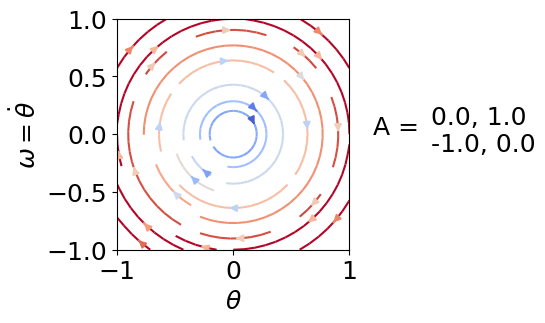

In [6]:
# Plotting phase portraits
def plot_phase_portrait(A,n = 10, xlabel=r'$x_1$', ylabel=r'$x_2$', Alabel='A'):
    '''
    A: matrix 2x2
    n: number of points in the n x n grid
    '''
    plt.figure(figsize=(3,3))
    x1 = np.linspace(-1, 1, n) # a 1D grid
    x = np.array(np.meshgrid(x1, x1)).reshape((2,-1)) # a 2D flattened grid
    # calculate the time-derivative of the state x in the line below
    # the output shape should be [2 x n^2]
    x_dot = A @ x # 2remove
    x_dot = x_dot.reshape((2,n,n))
    plt.streamplot(x1,x1,*x_dot,color=np.linalg.norm(x_dot,axis=0),cmap='coolwarm',density=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel);
    plt.text(1.2,0,f'{Alabel} = ')
    plt.text(1.7,-.15,f'{A[0,0]:.1f}, {A[0,1]:.1f} \n{A[1,0]:.1f}, {A[1,1]:.1f}')
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.clim(vmin=0,vmax=1)

A = np.array([[0, 1], [-1, 0]]) # pendulum dynamics
plot_phase_portrait(A, xlabel=r'$\theta$', ylabel=r'$\omega = \dot\theta$')

Following these streamlines in a figure above from some initial point $x_0$ step-by-step corresponds to integrating $\int_{t_0}^{t} \dot x(t) dt$ that we did in the previous exercise!

Color here shows how fast the state evolves: cooler colors mean slower, warmer colors -- faster!
(darkest blue: $|\mathbf{\dot x}| = 0$, brightest red: $|\mathbf{\dot x}| = 1$)

Like in Izhekevich quote, we don't even need to write equation to tell how the system behaves 🤯

## Analysing multi-dimensional linear dynamical systems

### Change of basis
The pendulum example above is, perhaps, the simplest linear dynamical system in physics. Its phase portrait is symmetrical!

But for other dynamical systems, with other matrices $A$, this might not be the case:

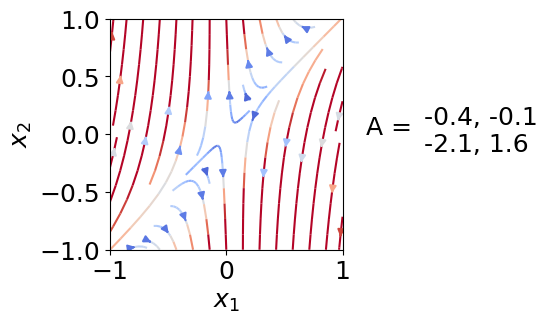

In [7]:
np.random.seed(2)
A = np.random.randn(2,2) # pick some values from N(0,1) for each component

plot_phase_portrait(A)


Looks very complicated! All elements in $A$ are non-zero, so each derivative $\dot x_i$ depends on both $x_1$ and $x_1$. Can we make it better? Can we somehow split a 2D system into a combination of two 1D systems?

We are now considering an abstract linear dynamical system, so the components $x_1$ and $x_2$ do not mean much... Can we stretch and rotate this space such that in these new coordinates $(\hat x_1, \hat x_2)$  the derivatives $d{\hat x_i}/dt$ only depend on the respective component $x_i$ ? Or, in other words, can we change the basis to make the matrix $A$ diagonal?

$$\begin{bmatrix}
\frac{d\hat x_1}{dt} \\
\frac{d\hat x_2}{dt}
\end{bmatrix} = \begin{bmatrix}
a_1 & 0 \\
0 & a_2
\end{bmatrix} \begin{bmatrix}
\hat x_1 \\
\hat x_2
\end{bmatrix} = \begin{bmatrix}
a_1 \hat x_1 \\
a_2 \hat x_2
\end{bmatrix}
$$

In [8]:
S = np.eye(2)
@widgets.interact
def rotate_and_scale(stretch=widgets.FloatLogSlider(min=-1, max=+1, value=1.,description='stretch ↕'),
                     rotate=widgets.FloatSlider(min=-90, max=+90, step=5 ,description='rotate ⤾')):
    global S
    a = rotate * np.pi / 180
    S =  np.array([[np.cos(a),np.sin(a)],[-np.sin(a),np.cos(a)]]) @ np.array([[stretch,0],[0,1]])
    plot_phase_portrait(S @ A @ np.linalg.inv(S),
                      xlabel=r'$\hat{x_1}$', ylabel=r'$\hat{x_2}$', Alabel=r'$\hat{A}$')


interactive(children=(FloatLogSlider(value=1.0, description='stretch ↕', max=1.0, min=-1.0), FloatSlider(value…

What we are doing above corresponds to this transformation:
$$S \mathbf{\dot x} = SA\mathbf{x} = SA\underbrace{(S^{-1}S)}_{I}\mathbf{x} = (SAS^{-1})S\mathbf{x}$$
or, in other words, we make the following change of coordinates (i.e. change of the basis):
$$\mathbf{x} \rightarrow S\mathbf{x} ~$$
$$A \rightarrow SAS^{-1}$$

#### Think!
Did you manage to align the *special* directions in the phase portrait above with the new axes? How does the new, transformed matrix $\hat{A} = SAS^{-1}$ look like?

**Solution:** stretch ~6.3 times and rotate by 10 degrees. It should produce a diagonal matrix A: -0.5, 1.7.

#### Real eigenvalues

What we did above by rotating and stretching our phase space is the transformation of matrix $A$ into its *canonical form*. Everything is simpler in this form! The eigenvalues remain the same under stretching and rotation:

$$\hat{A}\mathbf{\hat{x}} = SA\mathbf{x} = S\lambda x = \lambda \mathbf{\hat{x}}$$

Could you tell what are the eigenvalues of $\hat{A}$ without writing anything down?

Now, check your guess by calculating the eigenvalues:


In [9]:
A_hat = S @ A @ np.linalg.inv(S)
print('Eigenvalues of A    :', np.linalg.eig(A)[0])
print('Eigenvalues of A_hat:', np.linalg.eig(A_hat)[0])

Eigenvalues of A    : [-0.47361843  1.69713139]
Eigenvalues of A_hat: [-0.47361843  1.69713139]


Now let us experiment with the eigenvalues and understand what they *mean* in the dynamical system:

In [10]:
@widgets.interact
def rotate_and_scale(lambda_1=widgets.FloatSlider(min=-1, max=+1, description='λ1'),
                     lambda_2=widgets.FloatSlider(min=-1, max=+1, description='λ2')):
    lambda_1 = lambda_1 if type(lambda_1)==float else lambda_1.value
    lambda_2 = lambda_2 if type(lambda_2)==float else lambda_2.value
    if lambda_1==0 and lambda_2==0:
        lambda_1 = -1e-10
    A_12 = np.array([[lambda_1, 0],
                [0, lambda_2]])
    plot_phase_portrait(A_12)


interactive(children=(FloatSlider(value=0.0, description='λ1', max=1.0, min=-1.0), FloatSlider(value=0.0, desc…

Indeed, in a canonical form, the 2D system with two real eigenvalues splits into two independent 1D dynamical systems:
$\dot x_i = \lambda_i x_i, i \in \{0,1\}.$ So, each eigenvalue here changes the dynamics along its eigenvector the same way as the parameter $a$ in Example 1.

The eigenvectors are trivial in the canonical form: they are just aligned with axes!

So, in order to find eigenvectors of the original evolution matrix $A$, we simply need to reverse the rotation and stretching:

In [9]:
A_hat = S @ A @ np.linalg.inv(S)
print('Trivial eigenvectors of A_hat:', np.round(np.linalg.eig(A_hat)[1].T,1))
print('Eigenvectors of A:', np.round(np.linalg.eig(A)[1].T,2))
S_inv = np.linalg.inv(S) # invert the transform
S_inv_norm = S_inv / np.linalg.norm(S_inv,axis=0)
print('Vectors derived from transformation:', np.round(S_inv_norm.T,2))

Trivial eigenvectors of A_hat: [[-0.7 -0.7]
 [ 0.  -1. ]]
Eigenvectors of A: [[-0.7  -0.71]
 [ 0.03 -1.  ]]
Vectors derived from transformation: [[1. 0.]
 [0. 1.]]


The above vectors should be the almost identical (up to a sign).

#### Complex eigenvalues

From a characteristic polynomial, we know that the eigenvalues can be complex (as $\lambda = \lambda_{real} + i \lambda_{imag}$). We also found that eigenvalues connect high-dimensional systems (e.g. 2D) with some lower-dimensional (e.g. 1D) dynamic modes. Let us go back to a 1D system and try to make a coefficient $a$ complex.

#### Exercise 3: What if $a$ is complex-valued?

In the exercise 1 we found that analytical solution is:
$$x(t) = x_0 e^{at} $$
but what if $a$ is complex?

Let us substitute $a$ with $a_{real} + i a_{imag}$, then:
$$x(t) = x_0 e^{a_{real}t} e^{i a_{imag} t} $$

This new solution is a product of the solution that we have seen previously and a new term $e^{i a_{imag} t}$.

Let us generate some trajectories and see what happens:


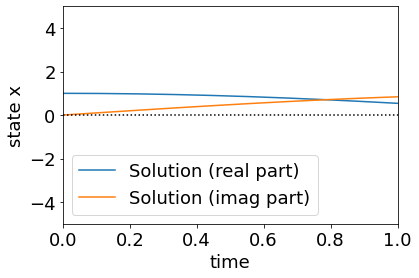

In [10]:
@widgets.interact
def plot_1D_solutions(x0 = 1., 
                      a_real = widgets.FloatSlider(min=-1., max=1., step=.1, value=0),
                      a_imag = widgets.FloatSlider(min=-1, max=5, step=.1, value=1)):
    a_real = a_real if type(a_real)==float else a_real.value
    a_imag = a_imag if type(a_imag)==float else a_imag.value
    a = complex(a_real,a_imag)
    plt.figure()
    time = np.linspace(0,T,n_plot)
    plt.plot(time, [analytical_1D_solution(x0,a,t).real for t in time],label='Solution (real part)')
    plt.plot(time, [analytical_1D_solution(x0,a,t).imag for t in time],label='Solution (imag part)')
    plt.xlim([0,T])
    plt.ylim([-5,5])
    plt.axhline(0,c='k',linestyle=':')
    plt.xlabel('time')
    plt.ylabel('state x')
    plt.legend(loc='lower left')


 Let us recall that $e^{i a_{imag} t} = \cos(a_{imag} t) + i\sin(a_{imag} t)$ (*Euler's formula*).

 So the whole solution looks like:
 $$x(t) = \underbrace{x_0 e^{a_{real} t} \cos(a_{imag}t)}_\mathrm{real~part} + \underbrace{i x_0 e^{a_{real} t} \sin(a_{imag}t)}_\mathrm{imaginary~part}$$


Let us return to the pendulum. What are the eigenvalues and eigenvectors for that 2D system?

In [12]:
A = np.array([[0, 1], [-1, 0]])
np.linalg.eig(A)

(array([0.+1.j, 0.-1.j]),
 array([[0.70710678+0.j        , 0.70710678-0.j        ],
        [0.        +0.70710678j, 0.        -0.70710678j]]))

#### **Think!**

What is the frequency of oscillations, based on these eigenvalues?

Since the solution is $e^{i\lambda_{im}t}$, then the full rotation corresponds to $2 \pi = \lambda_{im} T$, so $T = 2\pi/\lambda_{im}$ is the period of rotation.



#### Exercise 4. Zero eigenvalues

So far, we only looked at a full rank matrices $A$: such matrices that have all non-zero eigenvectors. What if one of them is actually zero?

**Solution:** If one of the eigenvectors is 0, then the solution does not change along the corresponding eignevector. The 2D problem becomes quasy-1D, but now instead of a fixed *point* we have a *line* attractor or repeller, aligned with a 0-eigenvalue eigenvector. We can visualize this using a widget above.

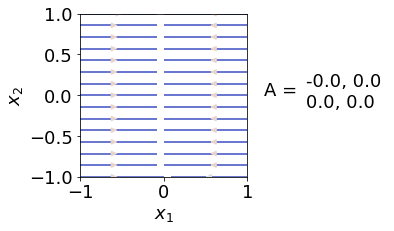

In [15]:
@widgets.interact
def rotate_and_scale(lambda_1=widgets.FloatSlider(min=-1, max=+1, description='λ1'),
                     lambda_2=widgets.FloatSlider(min=-1, max=+1, description='λ2')):
    lambda_1 = lambda_1 if type(lambda_1)==float else lambda_1.value
    lambda_2 = lambda_2 if type(lambda_2)==float else lambda_2.value
    if lambda_1==0 and lambda_2==0:
        lambda_1 = -1e-10
    A_12 = np.array([[lambda_1, 0],
                [0, lambda_2]])
    plot_phase_portrait(A_12)

### Fixed points and stability

**Fixed points** are the points that remain unchanged in time, meaning that the time derivative $\mathbf{\dot x}=\mathbf{0}$ there. There is only one such point in the linear systems which we considered above, which is $\mathbf{x}=\mathbf{0}$.

Fixed points can be stable and unstable. Stable means that once the state gets near the fixed point it will only get closer to it in the future (*more precisely it is called assymptotic stability*). Unstable means the opposite: the state only gets further away. The system can also be marginally stable, if it is neither stable nor unstable. 

A set of stable fixed points of a dynamical system is also called an **attractor**, while a set of unstable points -- a **repeller**.

### Exercise 5. Condition for stability?
*Hint: revise the 1D solutions and think about how the system behaves along the eigenvectors*

If 2x2 matrix $A$ has two eigenvalues: $\lambda_1$ and $\lambda_2$, what are the conditions for being 1) stable? 2) unstable?

**Solution:** 

1) the LDS is stable if the real-parts of **both** eigenvalues are strictly negative: $\mathrm{Re}(\lambda_1)<0~\mathrm{AND}~\mathrm{Re}(\lambda_2)<0$

2) the LDS is unstable if **at least** one eigenvalue has a strictly-positive real part: $\mathrm{Re}(\lambda_1)>0~\mathrm{OR}~\mathrm{Re}(\lambda_2)>0$


### Summary

We have explored DS with real-valued, complex and zero eigenvalues. And that is all possible dynamics one can get in 2D with a linear DS!

We can summarize all dynamic regimes in a single plot:

![Classification of Phase Portraits](https://drive.google.com/uc?export=view&id=1zvbMnqnSFiss3GF_yfUo83NxOD_WXZtK)

here $\Delta = (\lambda_1 - \lambda_2)^2$ sets the boundary between real-valued and complex-valued eigenvalues (you can also derive it from a characteristic polynomial)

### **Exercise 6** : relationship between continuous time and discrete time linear dynamical systems

Dynamical systems are systems that **evolve** in time. 
When modelling dynamics, we can represent time in two different ways: *discrete* or *continuous*. In both cases, we can write down the evolution of the system as a function of its previous `state' $\mathbf{x}$ and external inputs that the system receives $\mathbf{u}$:

Discrete time systems               |           Continuous time systems
------------------------------------|-------------------------------------
 $$\mathbf{x}_{t+1} = F_d(\mathbf{x}_t,\mathbf{u}_t)$$           |    $$\frac{d\mathbf{x}(t)}{dt} = F_c(\mathbf{x}(t),\mathbf{u}(t))$$
 

In the exercise above we were visualizing phase planes for the *continuous-time* dynamical systems. It is convinient, because there exists a derivative $\mathbf{\dot x}$, which we were plotting with streamplots.

However, when it comes to **numerical** integration, we typically use discrete time steps. We already applied one such discretization ( a forward Euler scheme) in Exercise 1.

Discrete time LDS               |           Continuous time LDS
------------------------------------|-------------------------------------
 $$\mathbf{x}_{t+1} = A_d \mathbf{x}_t$$           |    $$\frac{d\mathbf{x}(t)}{dt} = A_c\mathbf{x}(t)$$

### Exercise 6a: Relationship between evolution matrices

In this exercise, let us find the relationship between the continuous-time evolution matrix $A_c$ and the discrete-time matrix $A_d$ using forward Euler discretization. If we discretize the continuous system, then what would be the equivalent of a matrix $A_d$ in a discretized version?

#### **Solution:**
$ \frac{dx}{dt} \approx \frac{x_{n+1} - x_n}{\Delta t} = A_c x_n$

$x_{n+1} = ̱\underbrace{(I + A_c \Delta t)}_{A_d} x_n$



### Exercise 6b: Relationship between eigenspectra*
\**difficult exercise, you can check the solution if no time*

What eigenvalues of matrices $A_c$ and $A_d$ define a marginally stable system (that neither explodes, nor collapses)? Draw both margins of stability on a complex plane.

#### **Solution:** 

We have already learned that in continuous case, marginal stability corresponds to eigenvalues with $Re(\lambda_c) = 0$.

In a discrete case, a marginally stable solution means that the norm of the vector $x_n$ does not change, which can be achieved if $|\lambda_d|=1$. Such eigenvalues would correspond to all possible rotations of the vector $x_n$: $\lambda_d = e^{i \varphi}$.

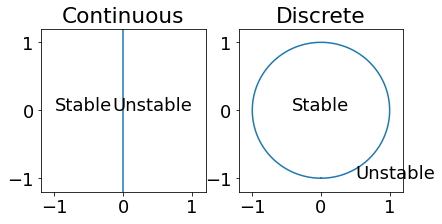

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(6.5,3))
ax[0].set_title('Continuous')
ax[0].axvline(0)
ax[0].text(-1,0.0,'Stable')
ax[0].text(1,0.0,'Unstable',horizontalalignment='right')

ax[1].set_title('Discrete')
a = np.linspace(-np.pi,+np.pi,100)
ax[1].plot(np.sin(a),np.cos(a))
ax[1].text(0,0.0,'Stable',horizontalalignment='center')
ax[1].text(0.5,-1,'Unstable',horizontalalignment='left')

for a in ax:
  a.set_xlim(-1.2,1.2)
  a.set_ylim(-1.2,1.2)

## **Exercise 7 (bonus):** practice reading eigenspectra from papers


### A spectrum of a continuous linearized E-I network

How does this continuous system behave? 
What dynamic modes do these eigenvalues describe?
Which eigenvalues are dominant?

![spectrum1](https://drive.google.com/uc?export=view&id=1OHb8jNNET8VFcBZtPhVCEqVBV8jmLguC)

**Answer** (from the original paper): The spectrum shows a conjugate complex eigenvalue pair with large real part. This pair of eigenvalues dominates the dynamics as their real parts are close to 1 and leads to the **periodic behaviour**.

The 'Balance' eigenvalue corresponds to a relaxation mode (decaying), and 'Random-like' mode corresponds to a degenerate dynamics akin to line attractor. 

*Maes, Amadeus, Mauricio Barahona, and Claudia Clopath. "Learning spatiotemporal signals using a recurrent spiking network that discretizes time." PLoS computational biology 16.1 (2020): e1007606.*


## Summary

In this tutorial, we learned:

1. What linear systems can and can not do
2. What fixed points are and how to check their stability
3. How to read eigenspectra of the dynamic state transition matrix

Now together we'll conclude:
4. How to relate the dynamics to computations on inputs (whiteboard)


# Projects (sorted from simpler to more complicated)

**Beginner (static):**
Generate your own neuronal network (function provided), but now with the responses to 2 stimuli, that evoke different average responses. Apply PCA, make a scree plot. How many dimensions do we need to explain the data? Select an optimal number of components (elbo) How well can we reconstruct the data from these components?

**Beginner (dynamic):**  Follow the bonus part of the tutorial to explore how the nonlinear dynamics of the Hodgkin-Huxley equation gives rise to action potentials. Using the phase portraits and nullclines (explined in the notebook), explain how the change of the voltage threshold affects the system and the number of fixed points.

**Intermediate (static):**
Visualize a hand movement task $[\mathrm{trials} \times \mathrm{time} \times \mathrm{neurons}]$ in a PCA space in 2 ways:
1. Calculate time-average responses per trial $[\mathrm{trials} \times \mathrm{neurons}]$ and reduce the neuronal population responses to a few dimensions. Visualize the result and label (color-code) different hand-reaching targets. Do they separate in the PC space?
2. Treat every timepoint independently $[(\mathrm{trials} \cdot \mathrm{time}) \times \mathrm{neurons}]$, apply PCA, connect the dots to visualize the *trajectories* in the latent space. Do they separate well in the PC space?

TODO: check part3 notebook

**Intermediate (dynamic):**  In this tutorial we considered mostly autonomous dynamical systems, including a line attractor. Although, a line attractor has interesting input-processing properties: it can integrate inputs! Implement a 2D line attractor with 1D external input (e.g. white noise):
$$\mathbf{\dot x} = A\mathbf{x} + B\mathbf{u} + \mathbf{b}$$
and demonstrate input integration. What should be the relationship between matrices $A$ and $B$ for integration to work?

**Intermediate (dynamic):** Between linear and non-linear models of dynamics, there is an intermediate class of models: piecewise-linear models. These models are linear within a certain area of a phase plane, but can generally exhibit quite complex behavior. Consider a 2D dynamical system:

$$\mathbf{\dot x} = {\begin{bmatrix}
    \dot x_1 \\
    \dot x_2
\end{bmatrix}} = \begin{cases} 
      A_-\mathbf{x} + \mathbf{b_-} & x_1 < 0 \\
      A_+\mathbf{x} + \mathbf{b_+} & x_1 \geq 0 
   \end{cases} $$

Implement this system and analyse its phase portrait and trajectories in the phase space. 

How does the stability depend on the parameters of the model? What is the period of oscillations?

Extra question$^*$: is it possible to obtain a figure-of-eight trajectory in such system?

**Hard (static):** Allen Brain data analysis (starter notebook will be provided; result -- high risk)
Calculate noise correlations during visual stimulus presentations on Allen Brain data. Using PCA, identify the ensambles in the neuronal population, which work together. 
 TODO: Ask Tom for an ensemble link

**Hard to extra-hard (both):** Merging dynamics with PCA
Generate observations from a linear dynamical system. Reduce the dimensionality and visualize the trajectories? Is the characteristic dynamics evident from the PC space? Explore the result for different eigenspectra.
*Potential extension for the second project:* infer the dynamics from the observed first PC components.

 

# References

1. Izhikevich, Eugene M. [Dynamical systems in neuroscience.](https://www.izhikevich.org/publications/dsn.pdf) MIT press, 2007.

2. Gerstner, Wulfram, et al. [Neuronal dynamics](https://neuronaldynamics.epfl.ch/index.html): From single neurons to networks and models of cognition. Cambridge University Press, 2014.

<!-- ## Other great tutorials: -->
3. Linear dynamical systems by Bing Wen Brunton and Alice Schwarze [Neuromatch: W2D2](https://compneuro.neuromatch.io/tutorials/W2D2_LinearSystems/student/W2D2_Tutorial1.html), 2020-now